# Thermal IR data exploration

### Wat am I trying to do?
1. Load in airborne IR data 
2. Define four 100m bounding boxes, 2 in open and in 2 in forest
3. Look at histogram
4. Do the same with different acquisitions 

### Some questions that are coming up here: 
* why only pyplot from matplotlib?
* how did you see timestamp in the filename?
* is there a way to see the stored variable - what happens if I jump between notebooks?

### Questions in view of next steps:
* canopy height model access?
* access to other images?

First, let's get the data, and check what's in there -> I'd like to see the files in this hidden directory, need to figure out how

In [12]:
!aws s3 sync --quiet s3://snowex-data/tutorial-data/thermal-ir/ /tmp/thermal-ir/

Now let's import the packages we need

In [13]:
# Import some general-purpose packages for handling different data structures
import numpy as np # for working with n-D arrays
import pandas as pd # for reading our csv data file and working with tabular data

# Import matplotlib which we'll use for plotting images and graphs
import matplotlib.pyplot as plt

# Import these packages for working with raster data
import xarray as xr # xarray lets us work with n-D arrays and labeled data, such as NetCDF files
import rioxarray # rioxarray provides capabilities of the rasterio package to xarray, letting us easily work with files such as GeoTIFFs

# Import some packages for working with the SnowEx SQL database
from snowexsql.db import get_db # Import the connection function from the snowexsql library
from  snowexsql.data import SiteData # Import the table classes from our data module which is where our ORM classes are defined 
from datetime import date # Import some tools to build dates 
from snowexsql.conversions import query_to_geopandas # Import a useful function for plotting and saving queries! See https://snowexsql.readthedocs.io/en/latest/snowexsql.html#module-snowexsql.conversions

Load the airborne image (netcdf file)

In [17]:
airborne_ir = xr.open_rasterio('/tmp/thermal-ir/SNOWEX2020_IR_PLANE_2020Feb08_mosaicked_2020-02-08T181915.tif')
airborne_ir

<xarray.DataArray (band: 1, y: 3848, x: 4398)>
[16923504 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.332e+06 4.332e+06 4.332e+06 ... 4.313e+06 4.313e+06
  * x        (x) float64 7.371e+05 7.371e+05 7.371e+05 ... 7.591e+05 7.591e+05
Attributes:
    transform:      (4.9992529765780835, 0.0, 737077.3666563785, 0.0, -4.9992...
    crs:            +init=epsg:32612
    res:            (4.9992529765780835, 4.99925297657805)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref

Take some conversion steps from Steven's tutorial just to make sure I understand them: coordinate system and timestamp, for better comparability with other datasets

In [18]:
airborne_ir = airborne_ir.rio.reproject('EPSG:26912')
airborne_ir_timestamp = pd.Timestamp(2020,2,8,18,19,15) - pd.Timedelta(hours=7)

Create data plot

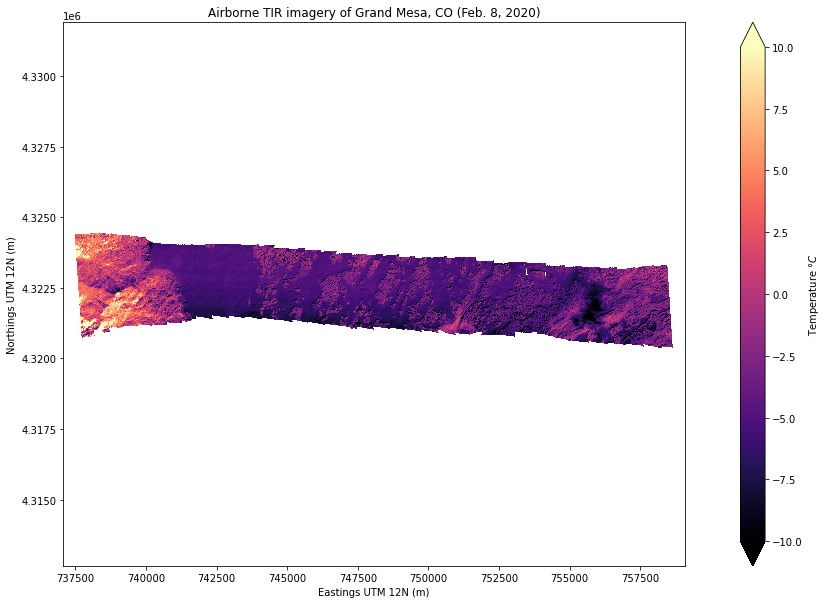

In [21]:
fig, ax = plt.subplots(figsize=(20,10)) # create a new matplotlib figure, set the figure size
ax.set_aspect('equal') # set the aspect ratio to "equal"

# plot the airborne infrared image
airborne_ir.plot(cmap='magma', vmin=-10, vmax=10,ax=ax, 
                 cbar_kwargs={'label': 'Temperature $\degree C$'})

# set axes labels
ax.set_xlabel('Eastings UTM 12N (m)')
ax.set_ylabel('Northings UTM 12N (m)')

ax.set_title('Airborne TIR imagery of Grand Mesa, CO (Feb. 8, 2020)');

Clip a 100 * 100 m tile

# clip 
airborne_ir_point_temperature = airborne_ir.rio.clip(siteData_df.geometry)

In [41]:
# This is what you will use for all of hackweek to access the db -> connect to it
db_name = 'snow:hackweek@52.32.183.144/snowex'
# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [42]:
# Form the query to receive site_id='2S10' from the sites table
qry = session.query(SiteData).filter_by(site_id='2S10')

# Convert the record received into a geopandas dataframe
siteData_df = query_to_geopandas(qry, engine)

In [43]:

r = 100 # radius of the buffer in meters (this is in meters because we are working in a UTM coordinate reference system) - waay too much

# create the buffered geometry
siteData_df_buffer = siteData_df.buffer(r)

In [44]:
# clip using our new geometry
airborne_ir_area_temperature = airborne_ir.rio.clip(siteData_df_buffer.geometry)

# preview the result
airborne_ir_area_temperature

<xarray.DataArray (band: 1, y: 40, x: 40)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 4.323e+06 4.323e+06 ... 4.323e+06 4.323e+06
  * x            (x) float64 7.43e+05 7.43e+05 7.43e+05 ... 7.432e+05 7.432e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('STCtemp',)
    AREA_OR_POINT:  Area
    description:    Airborne thermal infrared imagery from University of Wash...
    grid_mapping:   spatial_ref
    _FillValue:     nan